# Motivation
***
This notebook will discuss many different standard algorithms for implementing dimensionality reduction using the scikit-learn library.

Dimensionality reduction can be used to counteract the curse of dimensionality reduction, which is when machine learning algorithms become inefficient due to an extremely large feature space. 

Dimensionality reduction algorithms are used to project high-dimensional data to a low-dimensional space while retaining as much of the salient information as possible while removing redundant information. This enables supervised machine learning algorithms to identify interesting patterns more effectively because much of the noise will have been reduced. 

# The Data
***
We will be using the MNIST Digits database. One may acquire the pickled version [here](http://deeplearning.net/tutorial/gettingstarted.html).

This dataset is divided into a training set with 50,000 examples, a validation set with 10,000 examples and a test set with 10,000 examples. The data consist of 28x28 pixel images of handwritten digits. Each row of the data will be a flattened (28x28=784) dimensional vector. The values of the components of this vector are intensity values in the range zero to one, where zero is black and one is white. The labels are digits zero through nine. 

Standard Imports:

In [1]:
import os, time
import pickle, gzip 
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

Now we will load the data

In [2]:
filePath = "data/mnist.pkl.gz"
with gzip.open( filePath, 'rb' ) as file:
    train_set, validation_set, test_set = pickle.load( file, encoding='latin1' )

In [3]:
X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [4]:
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of y_train: {}".format(y_train.shape))

print("Shape of X_validation: {}".format(X_validation.shape))
print("Shape of y_validation: {}".format(y_validation.shape))

print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (50000, 784)
Shape of y_train: (50000,)
Shape of X_validation: (10000, 784)
Shape of y_validation: (10000,)
Shape of X_test: (10000, 784)
Shape of y_test: (10000,)


Now we will convert these number arrays to pandas DataFrames.

We will maintain the indices as though the three sets of data are vertically concatenated as a part of the same set.

In [5]:
train_index = range( len(X_train ) )
validation_index = range( len(X_train) , len(X_train) + len(X_validation) )
test_index = range( len(X_train) + len(X_validation) , len(X_train) + len(X_validation) + len(X_test) )

X_train = pd.DataFrame( data=X_train, index=train_index )
y_train = pd.DataFrame( data=y_train, index=train_index )

X_validation = pd.DataFrame( data=X_validation, index=validation_index )
y_validation = pd.DataFrame( data=y_validation, index=validation_index )

X_test = pd.DataFrame( data=X_test, index=test_index )
y_test = pd.DataFrame( data=y_test, index=test_index )

Here is a function to help us visualize the separation of points in space. This demonstrates the power of PCA to efficiently and compactly capture the variance in the data. We display a two dimensional scatterplot of the first and second principal components and color the points by the true label.

In [6]:
def scatterPlot(xDF, yDF, algName):
    """
    This function takes in the data after being projected onto principal components, 
    and the true labels, and it plots the data points, colored according to label
    """
    # access the first two principal components
    data = pd.DataFrame(data=xDF.loc[:, 0:1], index=xDF.index)
    data = pd.concat( (data, yDF), axis=1, join="inner" )
    data.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot( x="First Vector", y="Second Vector", hue="Label", data=data, fit_reg=False )
    ax = plt.gca()
    ax.set_title("Separation of Observations using {}".format(algName))

# Principal Component Analysis
***
We will set the number of principal components to be the original number of dimensions (784). Then, we can select however many principal components we want to project the data onto.

In [7]:
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2019


pca = PCA( n_components=n_components, whiten=whiten, random_state=random_state )

# 50000 rows, 784 columns
X_train_PCA = pca.fit_transform( X_train )
X_train_PCA = pd.DataFrame( data=X_train_PCA, index=train_index )

Because we have not reduced the dimensionality at all (we've used the same number of principal components as there are dimensions), we would expect all of the original information to be captured by all of the principal components:

In [8]:
print("Explained variance by all 784 principal components: {}".format(np.sum(pca.explained_variance_ratio_)))

Explained variance by all 784 principal components: 1.0


We will store the explained variance ratio inside a data frame and then we will use this to visualize the explained variance as a function of the number of principal components (sorted by the explained variance of the components - so the components that are more important come first)

In [9]:
importanceOfPrincipalComponents = pd.DataFrame(data=pca.explained_variance_ratio_)
# there is one row for each of the principal components
print(importanceOfPrincipalComponents.shape)

(784, 1)


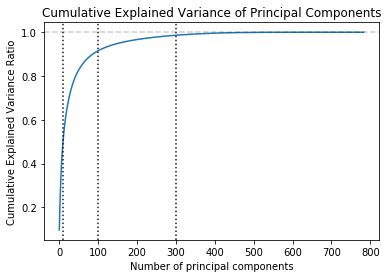

In [10]:
vertical_line_props = {'linestyle':':', 'alpha':0.9,'color':'black'}
cumulative_importance = np.cumsum(importanceOfPrincipalComponents)
plt.plot(cumulative_importance)
plt.title("Cumulative Explained Variance of Principal Components")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.axhline(1.0,color='black',linestyle='dashed',alpha=0.2)

plt.axvline(10, **vertical_line_props)
plt.axvline(100,**vertical_line_props)
plt.axvline(300,**vertical_line_props)
plt.show()

We can show that the first 10 components capture roughly 50% of the variance, the first 100 components capture over 90%, and the first three hundred components capture almost 99% of the variance in our dataset.

In [11]:
first_ten_index = 9
first_hundred_index = 99
first_three_hundred_index = 299
print("Variance captured by First 10 components: {:.2f}".format(cumulative_importance.loc[first_ten_index].values[0]))
print("Variance captured by First 100 components: {:.2f}".format(cumulative_importance.loc[first_hundred_index].values[0]))
print("Variance captured by First 300 components: {:.2f}".format(cumulative_importance.loc[first_three_hundred_index].values[0]))

Variance captured by First 10 components: 0.49
Variance captured by First 100 components: 0.91
Variance captured by First 300 components: 0.99


As one may see, we retain about 99% of the explained variance by just keeping the first 300 principal components. We could have reduced the dimensionality of our dataset by more than half and still kept a significant fraction of the information content.

Now, we will visualize the data after being projected onto the first two components:

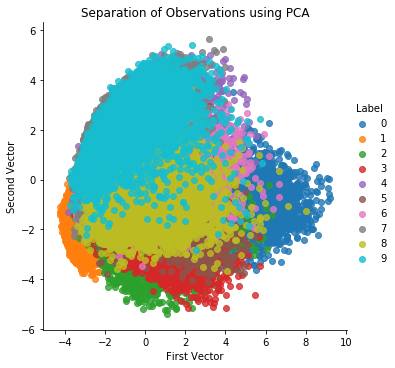

In [12]:
scatterPlot( X_train_PCA, y_train, "PCA" )

Aside from the fact that it's a nice looking visualization, we see that we do get nice clusters of data points that are determined to be similar, according to the information contained in the first two components. 

However, remember that we vastly sacrificed interpretability to get this nice visualization and reduction in dimensionality. I have no idea what it means to say that, "a given data point has a value of 2 for the first vector", in terms of the original data. It is just some linearly transformed version of the original components of the original data. 

## Incremental PCA
***
Incremental PCA is for when you have a dataset that is very large, and cannot fit into memory. Then, we will perform PCA in small batches, where each batch is able to fit in memory. The batch size can be either set manually or determined automatically. 

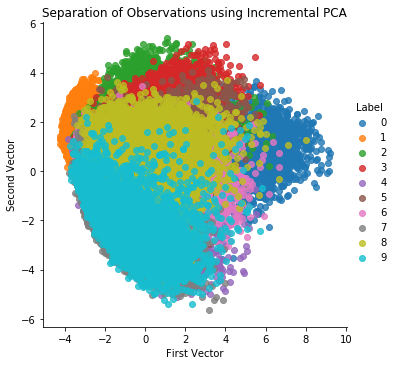

In [13]:
from sklearn.decomposition import IncrementalPCA

n_components = 784
batch_size = None

incremental_pca = IncrementalPCA( n_components=n_components , batch_size=batch_size )

X_train_incrementalPCA = incremental_pca.fit_transform(X_train)
X_train_incrementalPCA = pd.DataFrame( data=X_train_incrementalPCA, index=train_index )

X_validation_incrementalPCA = incremental_pca.fit_transform( X_validation )
X_validation_incrementalPCA = pd.DataFrame( data=X_validation_incrementalPCA, index=validation_index )

scatterPlot( X_train_incrementalPCA, y_train, "Incremental PCA" )

# Singular Value Decomposition
***
Singular value decomposition is used to learn the underlying structure of the data in order to reduce the rank of the original feature matrix into one of smaller rank, such that the original feature matrix can be recreated using a linear combination of the vectors in the smaller rank matrix.

SVD keeps the vectors of the original matrix that have the most information (the highest singular value). This is very similar to PCA. The difference is that, where PCA uses the eigen-decomposition of the covariance matrix, the SVD algorithm uses the singular value decomposition.

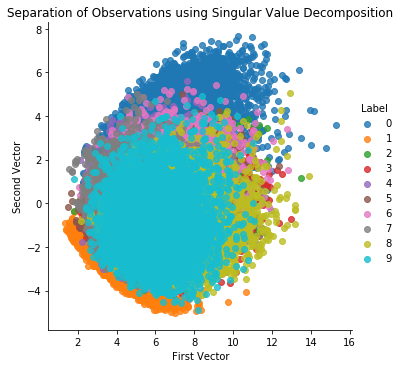

In [15]:
from sklearn.decomposition import TruncatedSVD

n_components = 200
algorithm = 'randomized'
n_iter = 5
random_state = 42

svd = TruncatedSVD( n_components=n_components, algorithm=algorithm, n_iter=n_iter, random_state=random_state )

X_train_svd = pd.DataFrame(data=svd.fit_transform(X_train), index=train_index)
X_validation_svd = pd.DataFrame(data=svd.transform(X_validation), index=validation_index)

scatterPlot( X_train_svd, y_train, "Singular Value Decomposition" )

# Random Projection
***
Random projection is a linear dimensionality reduction technique, which relies on the Johnson-Lindenstrauss lemma. This lemma states that points in a high-dimensional space can be embedded into a much lower-dimensional space so that distances between the points are nearly preserved. Read more about this lemma [here](https://cseweb.ucsd.edu/~dasgupta/papers/jl.pdf).

The standard version of random projection is called **Gaussian random projection**. In Gaussian random projection, we specify either the number of components we would like to have in the reduced feature space, or we set the hyperparameter `eps`, which controls the quality of the embedding according to the Johnson-Lindenstrauss lemma. Small values of `eps` correspond to a higher number of dimensions.

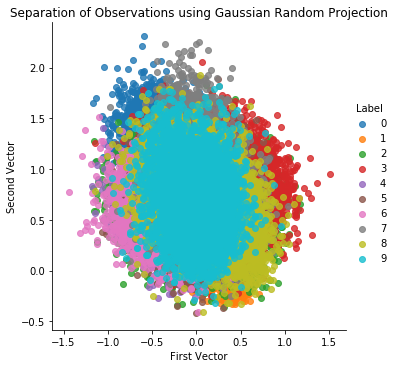

In [18]:
from sklearn.random_projection import GaussianRandomProjection

n_components = 'auto'
eps = 0.5
random_state=42

GRP = GaussianRandomProjection( n_components=n_components, eps=eps, random_state=random_state )

X_train_GRP = pd.DataFrame(data = GRP.fit_transform(X_train),index=train_index)
X_validation_GRP = pd.DataFrame(data=GRP.transform(X_validation), index=validation_index)

scatterPlot(X_train_GRP, y_train, "Gaussian Random Projection")

## Sparse Random Projection
***
If efficiency is an issue, we can use the sparse random projection, which retains some degree of sparsity in the transformed feature set and is generally more efficient than the Gaussian random projection (transforms the original data much faster than normal GRP). 

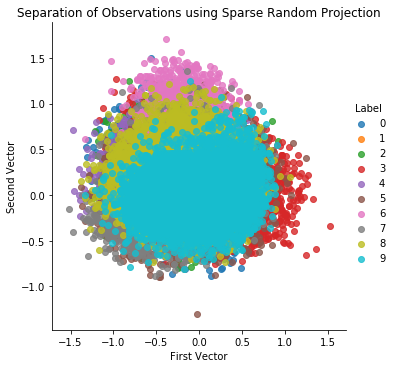

In [20]:
from sklearn.random_projection import SparseRandomProjection

n_components = 'auto'
density = 'auto'
eps = 0.5
dense_output = False
random_state=42

SRP = SparseRandomProjection( n_components=n_components, density=density, eps=eps, \
                             dense_output=dense_output, random_state=random_state )

X_train_SRP = pd.DataFrame(data = SRP.fit_transform(X_train),index=train_index)
X_validation_SRP = pd.DataFrame(data=SRP.transform(X_validation), index=validation_index)

scatterPlot(X_train_SRP, y_train, "Sparse Random Projection")

# Isomap
***
Isomap is a nonlinear dimensionality reduction method. Collectively, the nonlinear dimensionality reduction methods used to project the data from a high-dimensional space to a low-dimensional space is referred to as **manifold learning**.

The most vanilla form of manifold learning is known as **isometric mapping**, or **isomap** for short. Isomap learns a new low-dimensional embedding of the original feature set by calculating the pairwise distances of all the points, where the distance is now computed as the curved or _geodesic distance_ as opposed to the _euclidean distance_. In other words, this method learns the intrinsic geometry of the original data based on where each point lies relative to its neighbors on a manifold.

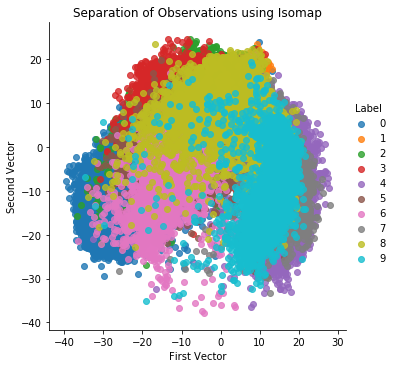

In [22]:
from sklearn.manifold import Isomap

n_neighbors = 5
n_components = 10
n_jobs = 8

isomap = Isomap( n_neighbors=n_neighbors, n_components=n_components, n_jobs=n_jobs )

# train the transformer on the first 5000 observations
isomap.fit( X_train.loc[0:5000,:] )

X_train_isomap = pd.DataFrame( data=isomap.transform(X_train), index=train_index )
X_validation_isomap = pd.DataFrame(data=isomap.transform(X_validation), index=validation_index)

scatterPlot( X_train_isomap, y_train, "Isomap")

# Multidimensional Scaling
***
Multidimensional scaling (MDS) is a form of nonlinear dimensionality reduction that learns the similarity of the points in the original dataset and, using this similarity, models this in a lower dimensional space.

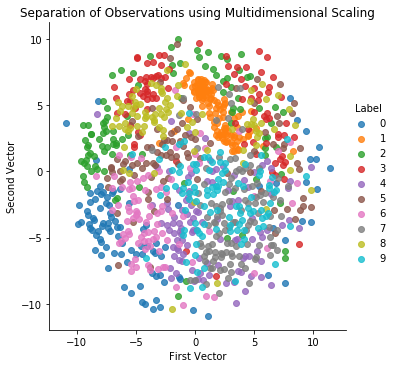

In [25]:
from sklearn.manifold import MDS

n_components = 2
n_init = 12
max_iter = 1200
metric=True
n_jobs=8
random_state=42

mds = MDS(n_components=n_components, n_init=n_init, max_iter=max_iter, metric=metric, n_jobs=n_jobs,\
          random_state=random_state)
X_train_mds = pd.DataFrame( data=mds.fit_transform(X_train.loc[0:1000,:]), index=train_index[0:1001] )

scatterPlot( X_train_mds, y_train, "Multidimensional Scaling")

# Locally Linear Embedding
***
Another popular nonlinear dimensionality reduction method is called _locally linear embedded_ (LLE). This method preserves distances within local neighborhoods as it projects the data from the original feature space to a reduced space. LLE discovers the nonlinear structure in the original high dimensional data by segmenting the data into smaller components (neighborhoods of points), and modeling each component as a linear embedding.

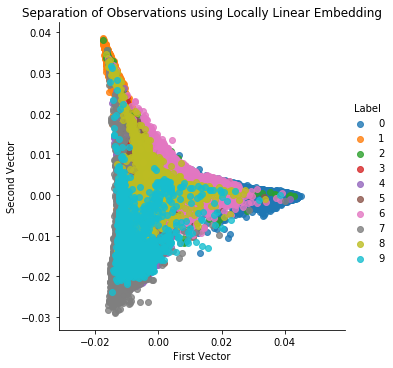

In [24]:
from sklearn.manifold import LocallyLinearEmbedding

n_neighbors=10
n_components=2
method='modified'
n_jobs=8
random_state=42

lle = LocallyLinearEmbedding( n_neighbors=n_neighbors, n_components=n_components, method=method, \
                            random_state=random_state, n_jobs=n_jobs )

# train on the first 5000 points
lle.fit( X_train.loc[:5000,:] )

X_train_lle = pd.DataFrame( data=lle.transform(X_train), index=train_index )
X_validation_lle = pd.DataFrame( data=lle.transform(X_validation),index=validation_index )

scatterPlot( X_train_lle, y_train, "Locally Linear Embedding" )

# t-Distributed Stochastic Neighbor Embedding (t-SNE)
***
t-distributed stochastic neighbor embedding is a nonlinear dimensionality reduction technique for visualizing high-dimensional data. t-SNE does this by modeling each point into a two or three-dimensional space where similar points are modeled close to each other and dissimilar points are modeled as farther away. 

t-SNE does this by constructing two probability distributions, one over pairs of points in the high-dimensional space and another over pairs of points in the low-dimensional space such that similar points have a high probability and dissimilar have a lower probability. t-SNE minimizes the Kullback-Leibler divergence between the two probability distributions. 

In practicality, it is best to use another dimensionality reduction technique (such as PCA) to reduce the number of dimensions before applying t-SNE. In doing this, we reduce the noise in the features that are fed into t-SNE and speed up the computation of the algorithm.

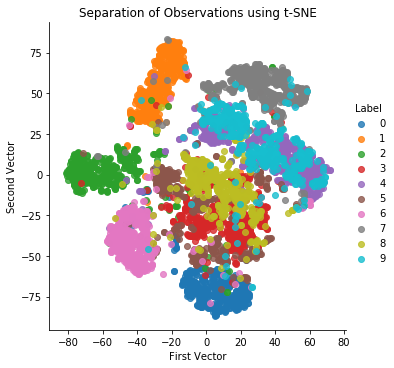

In [27]:
from sklearn.manifold import TSNE

n_components=2
learning_rate=300
perplexity=30
early_exaggeration=12
init='random'
random_state=42

tSNE = TSNE( n_components=n_components, learning_rate=learning_rate, perplexity=perplexity,\
           early_exaggeration=early_exaggeration, init=init, random_state=random_state )

X_train_tSNE = pd.DataFrame(data=tSNE.fit_transform(X_train_PCA.loc[:5000,:9]),index=train_index[:5001])
scatterPlot(X_train_tSNE,y_train,'t-SNE')

# Dictionary Learning
***
Dictionary learning does not rely on any sort of geometry or distance metric. Dictionary learning learns the sparse representation of the original data. The resulting matrix is known as the dictionary. The vectors in this matrix are known as _atoms_. The atoms are sparse, binary vectors. Each instance in the original data can be reconstructed as a weighed sum of the vectors.

If there are d features in the original data and n atoms in the dictionary, we can have a dictionary that is either _undercomplete_ (n<d), or _overcomplete_ (n>d). The undercomplete variety of dictionaries achieves dimensionality reduction, since we are representing the original data with a fewer number of vectors.

For this example, we will use a very dense dictionary since we want to visualize the images using a two-dimensional scatterplot. However, in reality, we might use a much more sparse dictionary.

/home/joseph/miniconda3/envs/unsupervisedLearning/lib/python3.6/site-packages/sklearn/decomposition/dict_learning.py:173: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T


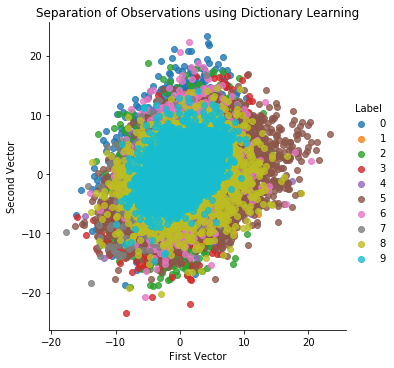

In [28]:
from sklearn.decomposition import MiniBatchDictionaryLearning

n_components=50
alpha=1
batch_size=200
n_iter=25
random_state=42

miniBatchDictLearning = MiniBatchDictionaryLearning( n_components=n_components, alpha=alpha, \
                                                   batch_size=batch_size, n_iter=n_iter, random_state=random_state )

miniBatchDictLearning.fit(X_train.loc[:,:10000])

X_train_miniBatchDictLearning = pd.DataFrame(data=miniBatchDictLearning.fit_transform(X_train),index=train_index)

scatterPlot( X_train_miniBatchDictLearning, y_train,"Dictionary Learning")

# Independent Component Analysis
***
Usually in data, there are many independent signals embedded together into the features we are given. Using independent component analysis_, we can separate blended signals into their individual components. After the separation is complete, we can reconstruct any of the original features by adding together some combination of the individual components we generated. ICA is usually used in signal processing tasks.

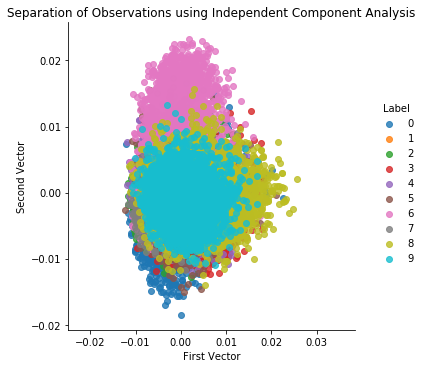

In [29]:
from sklearn.decomposition import FastICA

n_components=25
algorithm='parallel'
whiten=True
max_iter=100
random_state=42

fastICA = FastICA( n_components=n_components, algorithm=algorithm, whiten=whiten, max_iter=max_iter,\
                 random_state=random_state )

X_train_fastICA = pd.DataFrame( data=fastICA.fit_transform(X_train),index=train_index )

scatterPlot( X_train_fastICA, y_train, "Independent Component Analysis" )

# Summary
***
The linear methods are PCA and random projection, and the nonlinear methods (also known as manifold learning) are Isomap, multidimensional scaling, LLE and t-SNE. The nondistance-based methods are dictionary learning and ICA.

Dimensionality reduction captures the most salient information in a dataset in a small number of dimensions by learning the underlying structure of the data without using any labels.